In [1]:
from DELG_datasets.image_datasets import Kather100KDataset
from torchvision import transforms
from sentence_transformers import SentenceTransformer
import os
import matplotlib.pyplot as plt
import numpy as np
import faiss
import torch
import json



/Volumes/Untitled 2 1/3-CNN-Tensorflow/26-Pytorch/15-image-similarity-search/fish/DELG-Search/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-26 23:20:44.288144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model = SentenceTransformer('checkpoints/clip_vit_model').to("cpu")
model.eval()
sample = torch.rand(1, 3, 224, 224)
output = model.encode(sample)
print(output.shape)



In [9]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [28]:
# Function to extract features from a single image
def extract_features(input_tensor, model:SentenceTransformer):
    # input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension
    # print(input_tensor)
    try:
        with torch.no_grad():
            features = model.encode(input_tensor, convert_to_tensor=True)
    except Exception as e:
        import traceback; traceback.print_exc();
    return features.cpu().numpy()  # Convert to NumPy

def build_faiss_index(features, index_file):
    index = faiss.IndexFlatL2(features.shape[1])  # L2 distance
    index.add(features)  # Add feature vectors to index
    # Save index to file
    faiss.write_index(index, index_file)
    print(f"Index saved to {index_file}")
    return index

def load_or_build_index(features, index_file):
    if os.path.exists(index_file):
        print(f"Loading existing index from {index_file}")
        index = faiss.read_index(index_file)
    else:
        index = build_faiss_index(features, index_file)
    return index

def query_index(query_features, index, k=5):
    distances, indices = index.search(query_features, k)
    return distances, indices

# 8. Save index_to_class as a JSON file
def save_index_to_class(index_to_class, filename='index_to_class.json'):
    with open(filename, 'w') as f:
        json.dump(index_to_class, f)
    print(f"index_to_class saved to {filename}")

# 9. Load index_to_class from a JSON file
def load_index_to_class(filename='index_to_class.json'):
    with open(filename, 'r') as f:
        index_to_class = json.load(f)
    print(f"index_to_class loaded from {filename}")
    return index_to_class

# 10. Extract features for the entire dataset and build the index
def build_feature_index(dataset, model, transform, index_file, index_to_class_file):
    feature_list = []
    for i in range(len(dataset)):
        img, _ = dataset[i]
        # img = transform(img)  # Apply transformation
        # print(img)
        features = extract_features(img, model)
        feature_list.append(features)

    feature_array = np.vstack(feature_list).astype("float32")
    index = build_faiss_index(feature_array, index_file)
    
    # Save index_to_class for later use
    save_index_to_class(dataset.index_to_class, index_to_class_file)
    
    return index

IndexError: index 3 is out of bounds for axis 0 with size 3

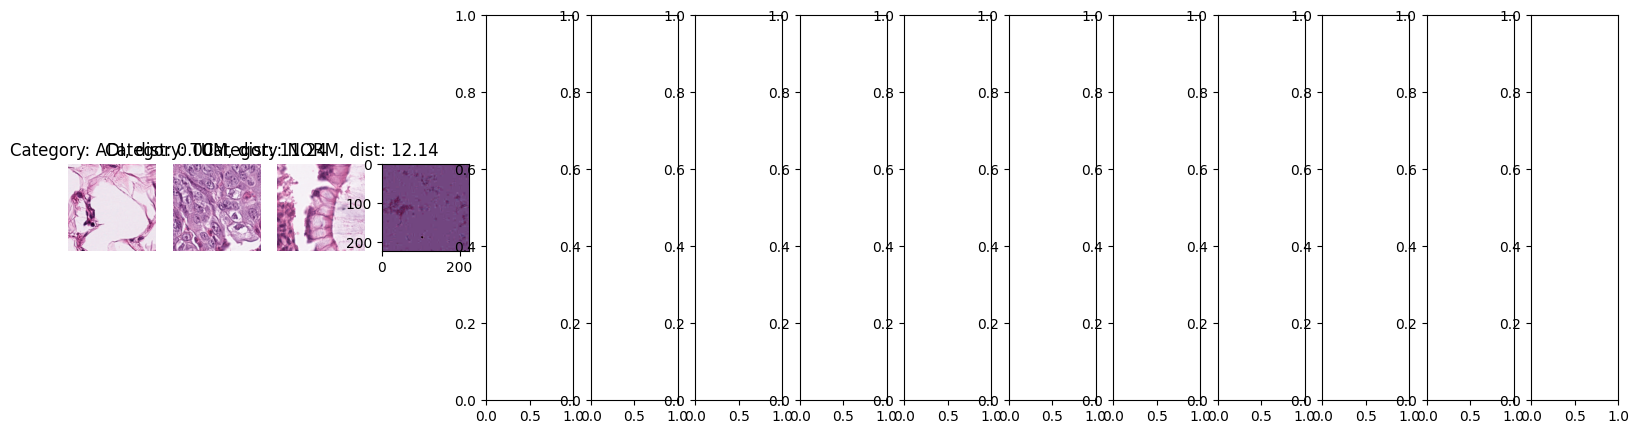

In [ ]:
kather100k_dataset = Kather100KDataset('kather100k')
index_to_class = kather100k_dataset.index_to_class
# plot 5 random images with their categories
fig, axes = plt.subplots(1, 15, figsize=(20, 5))
for i, ax in enumerate(axes):
    idx = np.random.randint(len(kather100k_dataset))
    image, category = kather100k_dataset[idx]
    ax.imshow(image)
    ax.set_title(f"Category: {index_to_class[category]}")
    ax.axis('off')
plt.show()

Index saved to kather100k_faiss.index
index_to_class saved to index_to_class.json


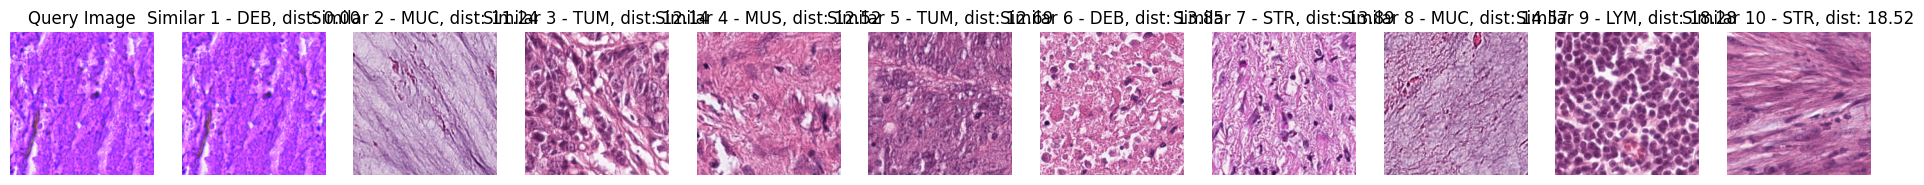

In [34]:
index_file = "kather100k_faiss.index"
index_to_class_file = "index_to_class.json"

index = build_feature_index(
    kather100k_dataset, model, preprocess, index_file, index_to_class_file
)

# Query the index
query_img, _ = kather100k_dataset[16]  # Take the first image as query
# query_img = preprocess(query_img)
query_vector = (
    extract_features(query_img, model).reshape(1, -1).astype(np.float32)
)  # Reshape for Faiss query
distances, indices = query_index(query_vector, index, k=10)

# Display the query image and similar images
fig, axes = plt.subplots(1, 11, figsize=(24, 4))
axes[0].imshow(query_img)
axes[0].set_title("Query Image")
axes[0].axis("off")

for i, ax in enumerate(axes[1:], 1):
    idx = indices[0][i - 1]
    img, _ = kather100k_dataset[idx]
    ax.imshow(img)
    ax.set_title(
        f"Similar {i} - {kather100k_dataset.index_to_class[kather100k_dataset.class_to_idx[kather100k_dataset.paths[idx].parent.name]]}, dist: {distances[0][i - 1]:.2f}"
    )
    ax.axis("off")

plt.show()